In [1]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import re
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from model import TransformerDecoderClassification, TransformerDecoderLinearWeights, TransformerDecoderRegression, TransformerDecoderRegressionLinearWeights
import ivon
from model_utils import parse_model_path, get_wd_from_std, compute_kld
from os import getenv
SYS_PATH = '/u/ajagadish/ermi'

In [2]:
def save_klds(data, env, max_steps, num_inputs):

    task_features = {'model_max_steps': max_steps}
    paired=True
    device='cpu'
    std=0.1
    lr=3e-4
    klds,lambadas, esses = [], [], []
    esses.extend([i for i in np.arange(10000, 100000, 10000)])
    esses.extend([i for i in np.arange(30000, 40000, 100)])
    esses = np.array(esses)
    esses.sort()
    
    for ess in esses:#np.arange(10000, 1000000, 10000):
        
        # parse model parameters
        model_path = f'{SYS_PATH}/decisionmaking/trained_models/env={env}_model=transformer_num_episodes100000_num_hidden=256_lr0.1_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedTrue_lossvariational_ess{str(ess)}_std0.1_run=0.pt'
        num_hidden, num_layers, d_model, num_head, loss_fn, model_max_steps = parse_model_path(model_path, task_features)
        # print(model_path)

        # initialise model
        if paired:
            model = TransformerDecoderLinearWeights(num_input=num_inputs, num_output=1, num_hidden=num_hidden,
                                                    num_layers=num_layers, d_model=d_model, num_head=num_head, max_steps=model_max_steps, loss=loss_fn, device=device).to(device)

        else:
            model = TransformerDecoderClassification(num_input=num_inputs, num_output=1, num_hidden=num_hidden,
                                                        num_layers=num_layers, d_model=d_model, num_head=num_head, max_steps=model_max_steps, loss=loss_fn, device=device).to(device)

        
        # try:
        # import ipdb; ipdb.set_trace()
        aa = torch.load(model_path, map_location=torch.device('cpu'))
        model.load_state_dict(aa[1])

        lambda_ = len(pd.read_csv(f'{SYS_PATH}/decisionmaking/data/{data}.csv')) if ess is None else ess
        wd = get_wd_from_std(std, lambda_)
        optimizer = ivon.IVON(model.parameters(), lr=lr, ess=lambda_, weight_decay=wd)
        optimizer.load_state_dict(aa[2])

        kld = compute_kld(optimizer, std)
        lambadas.append(lambda_)
        klds.append(kld)
        # except:
        #      print(ess)

    # save klds
    df = pd.DataFrame({'lambda': lambadas, 'kld': klds})
    df.to_csv(f'{SYS_PATH}/decisionmaking/data/stats/klds_{env}.csv', index=False)

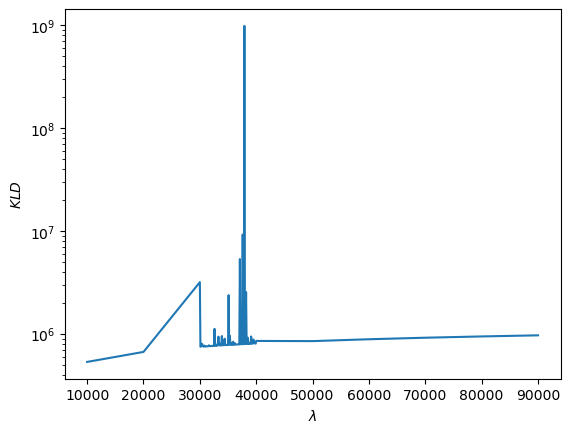

In [3]:
save_klds(data='claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown', env='claude_dim2', max_steps=10, num_inputs=2)
data_klds = pd.read_csv('/u/ajagadish/ermi/decisionmaking/data/stats/klds_claude_dim2.csv')
plt.plot(data_klds['lambda'].values, data_klds.kld.values)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('$KLD$')
plt.show()